# MASS database inspection (K-Complexes)

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec
import numpy as np
import pprint

detector_path = '..'
sys.path.append(detector_path)

from sleep.mass_k import MASSK
from sleep.mass_k import KEY_EEG, KEY_PAGES, KEY_ID, KEY_MARKS
from sleep.data_ops import seq2inter, inter2seq, seq2inter_with_pages
from evaluation.metrics import by_sample_confusion, by_sample_iou, by_event_confusion, matching

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

ModuleNotFoundError: No module named 'sleep'

In [3]:
dataset = MASSK(load_checkpoint=True)

Dataset mass_k with 15 patients.
Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Loading from checkpoint... Loaded


## Checking general numbers

In [4]:
print('Sample frequency:', dataset.fs)
print('Page duration and size:', dataset.page_duration, dataset.page_size)
print('Registers ids:', dataset.all_ids)
print('Number of loaded registers:', len(dataset.data))
print('')
print('Train set IDs:', dataset.train_ids)
print('Test set IDs:', dataset.test_ids)

Sample frequency: 200
Page duration and size: 20 4000
Registers ids: [1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 17, 18, 19]
Number of loaded registers: 15

Train set IDs: [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test set IDs: [2, 6, 12, 13]


## Check one subject

In [5]:
def plot_subject_global(signal, fs, pages, page_size, marks_1):
    time_axis = np.arange(signal.size) / fs
    max_time = time_axis[-1]
    
    n_pages = np.ceil(signal.size / page_size).astype(int)
    n2_stages = np.zeros(n_pages, dtype=np.uint8)
    for page in pages:
        n2_stages[page] = 1
    
    marks_1_in_page = np.zeros(n_pages, dtype=np.int32)
    marks_1_n2_without_marks = 0
    for page in pages:
        start_sample = page * page_size
        end_sample = (page+1) * page_size
        marks_1_presence = np.sum(marks_1[start_sample:end_sample])
        if marks_1_presence == 0:
            marks_1_n2_without_marks += 1
        marks_1_in_page[page] = marks_1_presence
    
    print('Number of N2 pages without E1 marks: %d' % marks_1_n2_without_marks)
    
    fig, ax = plt.subplots(3, 1, figsize=(15, 5))
    
    ax[0].set_title('Normalized EEG Signal')
    ax[0].plot(time_axis, signal)
    ax[0].set_xlabel('Time [s]')
    ax[0].set_xlim([0, max_time])

    ax[1].set_title('N2 stages (white is active)')
    ax[1].imshow(n2_stages[np.newaxis, :], interpolation=None, aspect='auto', cmap='gray', extent=[0, max_time, 0, 1])
    ax[1].axis('off')
    
    ax[2].set_title('E1 marks presence (white is active)')
    ax[2].imshow(marks_1_in_page[np.newaxis, :], interpolation=None, aspect='auto', extent=[0, max_time, 0, 1], cmap='gray')
    ax[2].axis('off')
    
    plt.tight_layout()
    plt.show()

### Complete register visualization

In [12]:
# Registers ids: [1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 17, 19]
subject_id = 1

In [13]:
ind_idx = dataset.all_ids.index(subject_id)
ind_dict = dataset.data[ind_idx]
subject_id = ind_dict[KEY_ID]
signal = ind_dict[KEY_EEG]
pages = ind_dict[KEY_PAGES]
marks_1 = ind_dict['%s_1' % KEY_MARKS]

print('Loaded subject ID %s' % subject_id)
print('Signal size %d. Number of pages %d' % (signal.shape[0], pages.shape[0]))

Loaded subject ID 1
Signal size 5791600. Number of pages 745


Number of N2 pages without E1 marks: 452


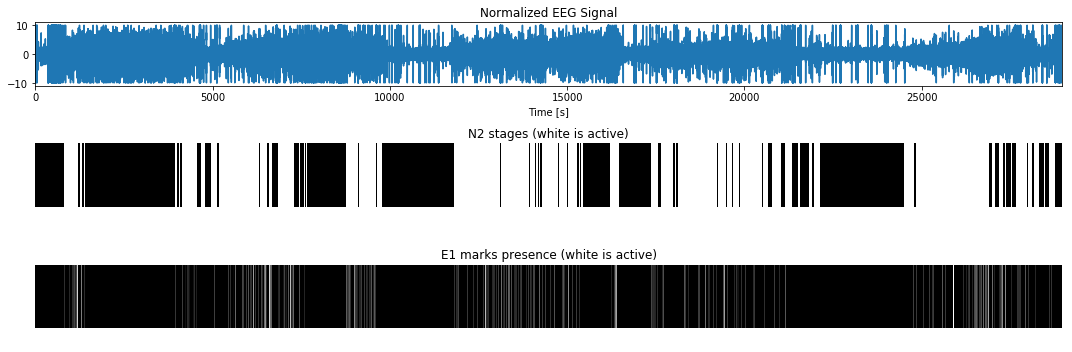

In [14]:
plot_subject_global(signal, dataset.fs, pages, dataset.page_size, marks_1)

## Marks statistics from saved data

In [15]:
marks_1_stamps = seq2inter(marks_1)
print('Number of marks from E1: %d' % marks_1_stamps.shape[0])

Number of marks from E1: 409


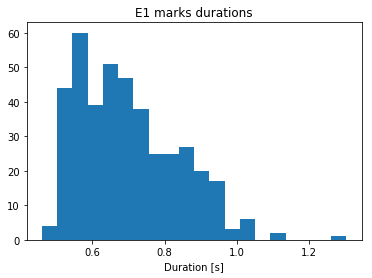

In [16]:
durations_1 = np.diff(marks_1_stamps)[:, 0] / dataset.fs

fig, ax = plt.subplots(1, 1)
ax.hist(durations_1, bins=20)
ax.set_title('E1 marks durations')
ax.set_xlabel('Duration [s]')
plt.show()

## Page visualization

In [17]:
n2_signal, n2_marks_1 = dataset.get_subject_data(subject_id, which_expert=1, verbose=True)
pages = dataset.get_subject_pages(subject_id)

Getting ID 1, 745 N2 pages, Expert 1


In [18]:
print('Number of n2 pages:', n2_signal.shape)
tmp = np.sum(n2_marks_1, axis=1)
tmp = sum((tmp==0).astype(int))
print('Number of pages without E1 marks:', tmp)

Number of n2 pages: (745, 4000)
Number of pages without E1 marks: 452


In [19]:
n2_marks_1_stamps = seq2inter_with_pages(n2_marks_1, pages)
print('Number of E1 marks:', n2_marks_1_stamps.shape)

Number of E1 marks: (403, 2)


In [47]:
n2_marks_1[0, :].shape

(4000,)

In [66]:
# make a color map of fixed colors
cmap = colors.ListedColormap(['white', '#c62828'])

def plot_page(page, signal, e1_marks, n2_pages, fs):
    fig, ax = plt.subplots(1, 1, figsize=(15, 2), dpi=150)
    
    page = page - 1
    
    segment_signal = signal[page, :]
    segment_e1_marks = e1_marks[page, :]
    time_axis = np.arange(signal.shape[1])/fs   
    
    
    # Signal
    y_max = 10
    ax.plot(time_axis, segment_signal, linewidth=1, color='#455a64', label='EEG C3-CLE')
    ax.fill_between(time_axis, y_max * segment_e1_marks, -y_max * segment_e1_marks, facecolor='#c62828', alpha=0.3, label='K-Complex')
    ax.set_yticks([])
    ax.set_xlim([0, 20])
    ax.set_ylim([-y_max, y_max])
    ax.set_title('Subject %d (MASS). Page in record: %d (intervals of 0.5s are shown).' 
                 % (subject_id, n2_pages[page]), fontsize=10)
    ax.set_xticks([0, 5, 10, 15, 20])
    ax.set_xticks(np.arange(0, 20, 0.5), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    lg = ax.legend(loc='upper right', fontsize=8.5)
    # lh = lg.legendHandles[1]
    # lh.set_facecolor(lh.get_facecolor())
    # lh.set_alpha(1.0)
    ax.tick_params(labelsize=8.5)
    
    plt.tight_layout()
    plt.show()

In [67]:
widgets.interact(
    lambda page: plot_page(page, n2_signal, n2_marks_1, pages, dataset.fs),
    page=widgets.IntSlider(min=1,max=n2_signal.shape[0],step=1,value=1, continuous_update=False));

interactive(children=(IntSlider(value=1, continuous_update=False, description='page', max=745, min=1), Output(…